In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.rcParams['figure.dpi']= 100

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.feature_selection import chi2
from sklearn.metrics import cohen_kappa_score



plt.style.use('seaborn-colorblind')
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

/var/folders/7d/yk6lydf149v8792dnvq8l5g00000gn/T/ipykernel_3775/1055305786.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


In [2]:
training_set  = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
training_set.sample()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
9712,15662,6,In the @ORGANIZATION1 there where many problems that where faced durring the build. The Way that...,0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
pip install language_tool_python

  Obtaining dependency information for language_tool_python from https://files.pythonhosted.org/packages/d2/82/feb4f01e269267021f1e3a3bb87ad60b201d3fa36dfe9fb85684c025f43a/language_tool_python-2.8-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [6]:
import language_tool_python
from datetime import datetime
import pandas as pd

tool = language_tool_python.LanguageTool('en-US')

t0 = datetime.now()

training_set['matches'] = training_set['essay'].apply(lambda txt: tool.check(txt))
training_set['corrections'] = training_set['matches'].apply(len)
training_set['corrected'] = training_set.apply(lambda row: tool.correct(row['essay']), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

training_set.to_pickle('training_corr.pkl')

Processing time: 0:25:48.181136


In [7]:
training_set = pd.read_pickle('training_corr.pkl')

In [11]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [15]:
import string
import warnings
from datetime import datetime
import pandas as pd
import spacy

warnings.filterwarnings('ignore')

sents = []
tokens = []
lemma = []
pos = []
ner = []

stop_words = set(STOP_WORDS)
stop_words.update(string.punctuation)

nlp = spacy.load('en_core_web_sm')

t0 = datetime.now()

for essay in nlp.pipe(training_set['corrected'], batch_size=100):
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
        sents.append([sent.strip() for sent in essay.text.split('\n')])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

training_set['tokens'] = tokens
training_set['lemma'] = lemma
training_set['pos'] = pos
training_set['sents'] = sents
training_set['ner'] = ner

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:06:48.128073


In [16]:
training_set.to_pickle('training_spacy.pkl')

In [17]:
training_set.sample(7)

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,matches,corrections,corrected,tokens,lemma,pos,sents,ner
9157,15107,6,There are many obstacles faced because of letting the dirigibles dock at the Empire State Buildi...,2,3,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Offset 218, length 5, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found....",2,There are many obstacles faced because of letting the dirigibles dock at the Empire State Buildi...,"[There, are, many, obstacles, faced, because, of, letting, the, dirigibles, dock, at, the, Empir...","[there, be, many, obstacle, face, because, of, let, the, dirigible, dock, at, the, Empire, State...","[PRON, VERB, ADJ, NOUN, VERB, SCONJ, ADP, VERB, DET, NOUN, VERB, ADP, DET, PROPN, PROPN, PROPN, ...",[There are many obstacles faced because of letting the dirigibles dock at the Empire State Build...,"[the Empire State Building, First, the Empire State Building, the State Building]"
12314,20793,8,The night was dark and cloudy giving my surroundings a gloomy figure. Shadows slithered across ...,20,22,NaN,42,NaN,NaN,NaN,4.0,4.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Offset 184, length 4, Rule ID: COMMA_COMPOUND_SENTENCE\nMessage: Use a comma before ‘and’ if it...",9,The night was dark and cloudy giving my surroundings a gloomy figure. Shadows slithered across ...,"[ , The, night, was, dark, and, cloudy, giving, my, surroundings, a, gloomy, figure, ., Shadows,...","[ , the, night, be, dark, and, cloudy, give, my, surrounding, a, gloomy, figure, ., shadow, slit...","[SPACE, DET, NOUN, AUX, ADJ, CCONJ, ADJ, VERB, PRON, NOUN, DET, ADJ, NOUN, PUNCT, NOUN, VERB, AD...",[The night was dark and cloudy giving my surroundings a gloomy figure. Shadows slithered across ...,"[Earlier that day, I.D., only half an inch, @CAPS1, That day, ten, Laughter, one day]"
7042,10606,4,The author concludes the story with this paragraph because Saeng will return to the flowers agai...,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Offset 59, length 5, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found.\...",1,The author concludes the story with this paragraph because Sang will return to the flowers again...,"[The, author, concludes, the, story, with, this, paragraph, because, Sang, will, return, to, the...","[the, author, conclude, the, story, with, this, paragraph, because, Sang, will, return, to, the,...","[DET, NOUN, VERB, DET, NOUN, ADP, DET, NOUN, SCONJ, PROPN, AUX, VERB, ADP, DET, NOUN, ADV, ADP, ...",[The author concludes the story with this paragraph because Sang will return to the flowers agai...,"[Sang, the spring]"
1928,3123,2,I believe censorship should be used in libraries to a certain extent. There are too many childre...,4,4,NaN,4,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Offset 190, length 4, Rule ID: WHITESPACE_RULE\nMessage: Possible typo: you repeated a whitespa...",6,I believe censorship should be used in libraries to a certain extent. There are too many childre...,"[I, believe, censorship, should, be, used, in, libraries, to, a, certain, extent, ., There, are,...","[I, believe, censorship, should, be, use, in, library, to, a, certain, extent, ., there, be, too...","[PRON, VERB, NOUN, AUX, AUX, VERB, ADP, NOUN, ADP, DET, ADJ, NOUN, PUNCT, PRON, VERB, ADV, ADJ, ...",[I believe censorship should be used in libraries to a certain extent. There are too many childr...,[about one]
3437,4632,2,@CAPS1 happened to using books and films as simple entertainment? Why are we now 

In [18]:
reference_essays = {1: 161, 2: 3022, 3: 5263, 4: 5341, 5: 7209, 6: 8896, 7: 11796, 8: 12340}

references = {}

t0 = datetime.now()

nlp = spacy.load('en_core_web_sm')
stop_words = set(STOP_WORDS)

for topic, index in reference_essays.items():
    references[topic] = nlp(training_set.iloc[index]['essay'])

training_set['similarity'] = training_set.apply(lambda row: nlp(row['essay']).similarity(references[row['topic']]), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:07:39.725424


In [20]:
t0 = datetime.now()

training_set['token_count'] = training_set.apply(lambda x: len(x['tokens']), axis=1)
training_set['unique_token_count'] = training_set.apply(lambda x: len(set(x['tokens'])), axis=1)
training_set['nostop_count'] = training_set \
            .apply(lambda x: len([token for token in x['tokens'] if token not in stop_words]), axis=1)
training_set['sent_count'] = training_set.apply(lambda x: len(x['sents']), axis=1)
training_set['ner_count'] = training_set.apply(lambda x: len(x['ner']), axis=1)
training_set['comma'] = training_set.apply(lambda x: x['corrected'].count(','), axis=1)
training_set['question'] = training_set.apply(lambda x: x['corrected'].count('?'), axis=1)
training_set['exclamation'] = training_set.apply(lambda x: x['corrected'].count('!'), axis=1)
training_set['quotation'] = training_set.apply(lambda x: x['corrected'].count('"') + x['corrected'].count("'"), axis=1)
training_set['organization'] = training_set.apply(lambda x: x['corrected'].count(r'@ORGANIZATION'), axis=1)
training_set['caps'] = training_set.apply(lambda x: x['corrected'].count(r'@CAPS'), axis=1)
training_set['person'] = training_set.apply(lambda x: x['corrected'].count(r'@PERSON'), axis=1)
training_set['location'] = training_set.apply(lambda x: x['corrected'].count(r'@LOCATION'), axis=1)
training_set['money'] = training_set.apply(lambda x: x['corrected'].count(r'@MONEY'), axis=1)
training_set['time'] = training_set.apply(lambda x: x['corrected'].count(r'@TIME'), axis=1)
training_set['date'] = training_set.apply(lambda x: x['corrected'].count(r'@DATE'), axis=1)
training_set['percent'] = training_set.apply(lambda x: x['corrected'].count(r'@PERCENT'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['adj'] = training_set.apply(lambda x: x['pos'].count('ADJ'), axis=1)
training_set['pron'] = training_set.apply(lambda x: x['pos'].count('PRON'), axis=1)
training_set['verb'] = training_set.apply(lambda x: x['pos'].count('VERB'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['cconj'] = training_set.apply(lambda x: x['pos'].count('CCONJ'), axis=1)
training_set['adv'] = training_set.apply(lambda x: x['pos'].count('ADV'), axis=1)
training_set['det'] = training_set.apply(lambda x: x['pos'].count('DET'), axis=1)
training_set['propn'] = training_set.apply(lambda x: x['pos'].count('PROPN'), axis=1)
training_set['num'] = training_set.apply(lambda x: x['pos'].count('NUM'), axis=1)
training_set['part'] = training_set.apply(lambda x: x['pos'].count('PART'), axis=1)
training_set['intj'] = training_set.apply(lambda x: x['pos'].count('INTJ'), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))
training_set.to_pickle('training_features.pkl')

Processing time: 0:00:01.789464


In [21]:
training_set['matches'][0]

[Match({'ruleId': 'SPACE_BEFORE_PARENTHESIS', 'message': 'It appears that a white space is missing.', 'replacements': [' ('], 'offsetInContext': 43, 'context': '...w people, helps us learn about the globe(astronomy) and keeps us out of troble! T...', 'offset': 186, 'errorLength': 1, 'category': 'TYPOGRAPHY', 'ruleIssueType': 'typographical', 'sentence': 'Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble!'}),
 Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'message': 'Possible spelling mistake found.', 'replacements': ['trouble', 'treble'], 'offsetInContext': 43, 'context': '...he globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How wo...', 'offset': 218, 'errorLength': 6, 'category': 'TYPOS', 'ruleIssueType': 'misspelling', 'sentence': 'Dear local newspaper, I think effects computers have on

In [22]:
training_set['corrected'][0]

"Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe (astronomy) and keeps us out of trouble! Thing about! Don't you think so? How would you feel if your teenager is always on the phone with friends! Do you every time to chat with your friends or business partner about things? Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, Facebook, MySpace etc. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off because you want to use it. How did you learn about other countries/states outside yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the ec

In [23]:
training_set['tokens'][0]

['Dear',
 'local',
 'newspaper',
 ',',
 'I',
 'think',
 'effects',
 'computers',
 'have',
 'on',
 'people',
 'are',
 'great',
 'learning',
 'skills',
 '/',
 'affects',
 'because',
 'they',
 'give',
 'us',
 'time',
 'to',
 'chat',
 'with',
 'friends',
 '/',
 'new',
 'people',
 ',',
 'helps',
 'us',
 'learn',
 'about',
 'the',
 'globe',
 '(',
 'astronomy',
 ')',
 'and',
 'keeps',
 'us',
 'out',
 'of',
 'trouble',
 '!',
 'Thing',
 'about',
 '!',
 'Do',
 "n't",
 'you',
 'think',
 'so',
 '?',
 'How',
 'would',
 'you',
 'feel',
 'if',
 'your',
 'teenager',
 'is',
 'always',
 'on',
 'the',
 'phone',
 'with',
 'friends',
 '!',
 'Do',
 'you',
 'every',
 'time',
 'to',
 'chat',
 'with',
 'your',
 'friends',
 'or',
 'business',
 'partner',
 'about',
 'things',
 '?',
 'Well',
 'now',
 '-',
 'there',
 "'s",
 'a',
 'new',
 'way',
 'to',
 'chat',
 'the',
 'computer',
 ',',
 'theirs',
 'plenty',
 'of',
 'sites',
 'on',
 'the',
 'internet',
 'to',
 'do',
 'so',
 ':',
 '@ORGANIZATION1',
 ',',
 '@ORGANIZ

In [24]:
training_set['lemma'][0]

['dear',
 'local',
 'newspaper',
 ',',
 'I',
 'think',
 'effect',
 'computer',
 'have',
 'on',
 'people',
 'be',
 'great',
 'learning',
 'skill',
 '/',
 'affect',
 'because',
 'they',
 'give',
 'we',
 'time',
 'to',
 'chat',
 'with',
 'friend',
 '/',
 'new',
 'people',
 ',',
 'help',
 'we',
 'learn',
 'about',
 'the',
 'globe',
 '(',
 'astronomy',
 ')',
 'and',
 'keep',
 'we',
 'out',
 'of',
 'trouble',
 '!',
 'thing',
 'about',
 '!',
 'do',
 'not',
 'you',
 'think',
 'so',
 '?',
 'how',
 'would',
 'you',
 'feel',
 'if',
 'your',
 'teenager',
 'be',
 'always',
 'on',
 'the',
 'phone',
 'with',
 'friend',
 '!',
 'do',
 'you',
 'every',
 'time',
 'to',
 'chat',
 'with',
 'your',
 'friend',
 'or',
 'business',
 'partner',
 'about',
 'thing',
 '?',
 'well',
 'now',
 '-',
 'there',
 'be',
 'a',
 'new',
 'way',
 'to',
 'chat',
 'the',
 'computer',
 ',',
 'theirs',
 'plenty',
 'of',
 'site',
 'on',
 'the',
 'internet',
 'to',
 'do',
 'so',
 ':',
 '@ORGANIZATION1',
 ',',
 '@ORGANIZATION2',
 ',

In [25]:
training_set['ner'][0]

['Facebook, MySpace']

In [26]:
training_set = pd.read_pickle('training_features.pkl')

In [27]:
training_set.columns

Index(['essay_id', 'topic', 'essay', 'rater1_domain1', 'rater2_domain1', 'rater3_domain1', 'target_score', 'rater1_domain2', 'rater2_domain2', 'topic2_target', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1', 'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5', 'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3', 'rater3_trait4', 'rater3_trait5', 'rater3_trait6', 'matches', 'corrections',
       'corrected', 'tokens', 'lemma', 'pos', 'sents', 'ner', 'similarity', 'token_count', 'unique_token_count', 'nostop_count', 'sent_count', 'ner_count', 'comma', 'question', 'exclamation', 'quotation', 'organization', 'caps', 'person', 'location', 'money', 'time', 'date', 'percent', 'noun', 'adj', 'pron', 'verb', 'cconj', 'adv', 'det', 'propn', 'num', 'part', 'intj'],
      dtype='object')

In [28]:
training_set=training_set.drop(columns=['rater1_domain1','rater2_domain1','essay_id','rater3_domain1','rater1_domain2','rater2_domain2','rater1_trait1','rater1_trait2','rater1_trait3','rater1_trait4','rater1_trait5','rater1_trait6','rater2_trait1','rater2_trait2','rater2_trait3','rater2_trait4','rater2_trait5','rater2_trait6','rater3_trait1','rater3_trait2','rater3_trait3','rater3_trait4','rater3_trait5','rater3_trait6'])
training_set.sample(7)

,topic,essay,target_score,topic2_target,matches,corrections,corrected,tokens,lemma,pos,sents,ner,similarity,token_count,unique_token_count,nostop_count,sent_count,ner_count,comma,question,exclamation,quotation,organization,caps,person,location,money,time,date,percent,noun,adj,pron,verb,cconj,adv,det,propn,num,part,intj
571,1,"You must be insane! Computers are very important to society. My first reason is, computers can b...",8,NaN,"[Offset 354, length 4, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found....",13,"You must be insane! Computers are very important to society. My first reason is, computers can b...","[You, must, be, insane, !, Computers, are, very, important, to, society, ., My, first, reason, i...","[you, must, be, insane, !, computer, be, very, important, to, society, ., my, first, reason, be,...","[PRON, AUX, AUX, ADJ, PUNCT, NOUN, AUX, ADV, ADJ, ADP, NOUN, PUNCT, PRON, ADJ, NOUN, AUX, PUNCT,...","[You must be insane! Computers are very important to society. My first reason is, computers can ...","[first, Secondly, three, Firstly, WATS, first, Secondly, second]",0.877043,297,138,158,1,8,11,4,2,1,1,1,0,2,0,0,0,0,53,14,46,38,8,11,10,5,1,6,0
1521,1,"Dear @PERSON1, To this day, there are many people who use telecommunication devices, like the co...",10,NaN,"[Offset 132, length 8, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found....",13,"Dear @PERSON1, To this day, there are many people who use telecommunication devices, like the co...","[Dear, @PERSON1, ,, To, this, day, ,, there, are, many, people, who, use, telecommunication, dev...","[Dear, @PERSON1, ,, to, this, day, ,, there, be, many, people, who, use, telecommunication, devi...","[PROPN, PROPN, PUNCT, ADP, DET, NOUN, PUNCT, PRON, VERB, ADJ, NOUN, PRON, VERB, NOUN, NOUN, PUNC...","[Dear @PERSON1, To this day, there are many people who use telecommunication devices, like the c...","[this day, earth, millions, every day, four, Facebook, every day, all day]",0.916835,492,213,262,1,8,31,0,1,11,0,7,1,0,0,0,0,0,89,29,56,68,24,29,32,11,2,15,3
10118,6,The builders of the Empire state Building faced numerous technical and safety problems in creati...,4,NaN,"[Offset 20, length 21, Rule ID: EN_SPECIFIC_CASE\nMessage: If the term is a proper noun, use ini...",2,The builders of the Empire State Building faced numerous technical and safety problems in creati...,"[The, builders, of, the, Empire, State, Building, faced, numerous, technical, and, safety, probl...","[the, builder, of, the, Empire, State, Building, face, numerous, technical, and, safety, problem...","[DET, NOUN, ADP, DET, PROPN, PROPN, PROPN, VERB, ADJ, ADJ, CCONJ, NOUN, NOUN, ADP, VERB, DET, NO...",[The builders of the Empire State Building faced numerous technical and safety problems in creat...,"[the Empire State Building, First, first, German, Hindenburg, New York]",0.904819,216,128,124,1,6,10,0,0,2,0,1,0,0,0,0,0,0,45,20,6,29,2,15,25,7,2,8,0
10872,7,The day I stand for some free @CAPS1 of lays chips. When I was at @ORGANIZATION1 they was givein...,8,NaN,"[Offset 86, length 3, Rule ID: PERS_PRONOUN_AGREEMENT\nMessage: Use a third-person plural verb w...",17,The day I stand for some free @CAPS1 of lays chips. When I was at @ORGANIZATION1 they are given ...,"[The, day, I, stand, for, some, free, @CAPS1, of, lays, chips, ., When, I, was, at, @ORGANIZATIO...","[the, day, I, stand, for, some, free, @CAPS1, of, lay, chip, ., when, I, be, at, @ORGANIZATION1,...","[DET, NOUN, PRON, VERB, ADP, DET, ADJ, PROPN, ADP, NOUN, NOUN, PUNCT, SCONJ, PRON, AUX, ADP, PRO...",[The day I stand for some free @CAPS1 of lays chips. When I was at @ORGANIZATION1 they are given...,"[a giveaway day, four @NUM4 hours, Shaw, one]",0.782008,97,62,59,1,4,0,0,0,0,1,6,1,1,0,0,0,0,19,7,15,11,2,3,6,9,2,0,0
10516,6,"One of the obvious reasons is the height of all this taking place. The strong, always changing w...",3,NaN,"[Offset 400, length 9, Rule ID: AIRCRAFTS\nMessage: The plural of “aircraft” is

## Feature Selection


In [29]:
predictors = [  'corrections',
                'similarity',
                'unique_token_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'organization',
                'caps',
                'person',
                'location',
                'money',
                'time',
                'date',
                'percent',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'det',
                'propn',
                'num',
                'part',
                'intj'
                ]

In [30]:
X=training_set[predictors]
y=training_set['target_score']
best_features= SelectKBest(score_func=chi2,k=10)
fit=best_features.fit(X,y)

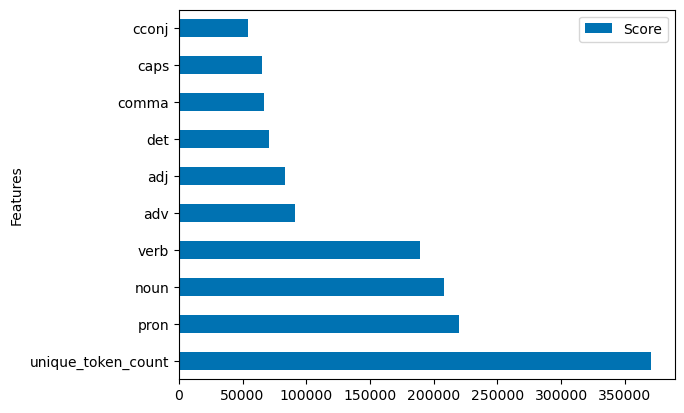

In [31]:
df_score=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,df_score],axis=1)
featureScores.columns=['Features','Score']
featureScores=featureScores.set_index('Features')
featureScores.nlargest(10,'Score').plot(kind='barh')
plt.show()

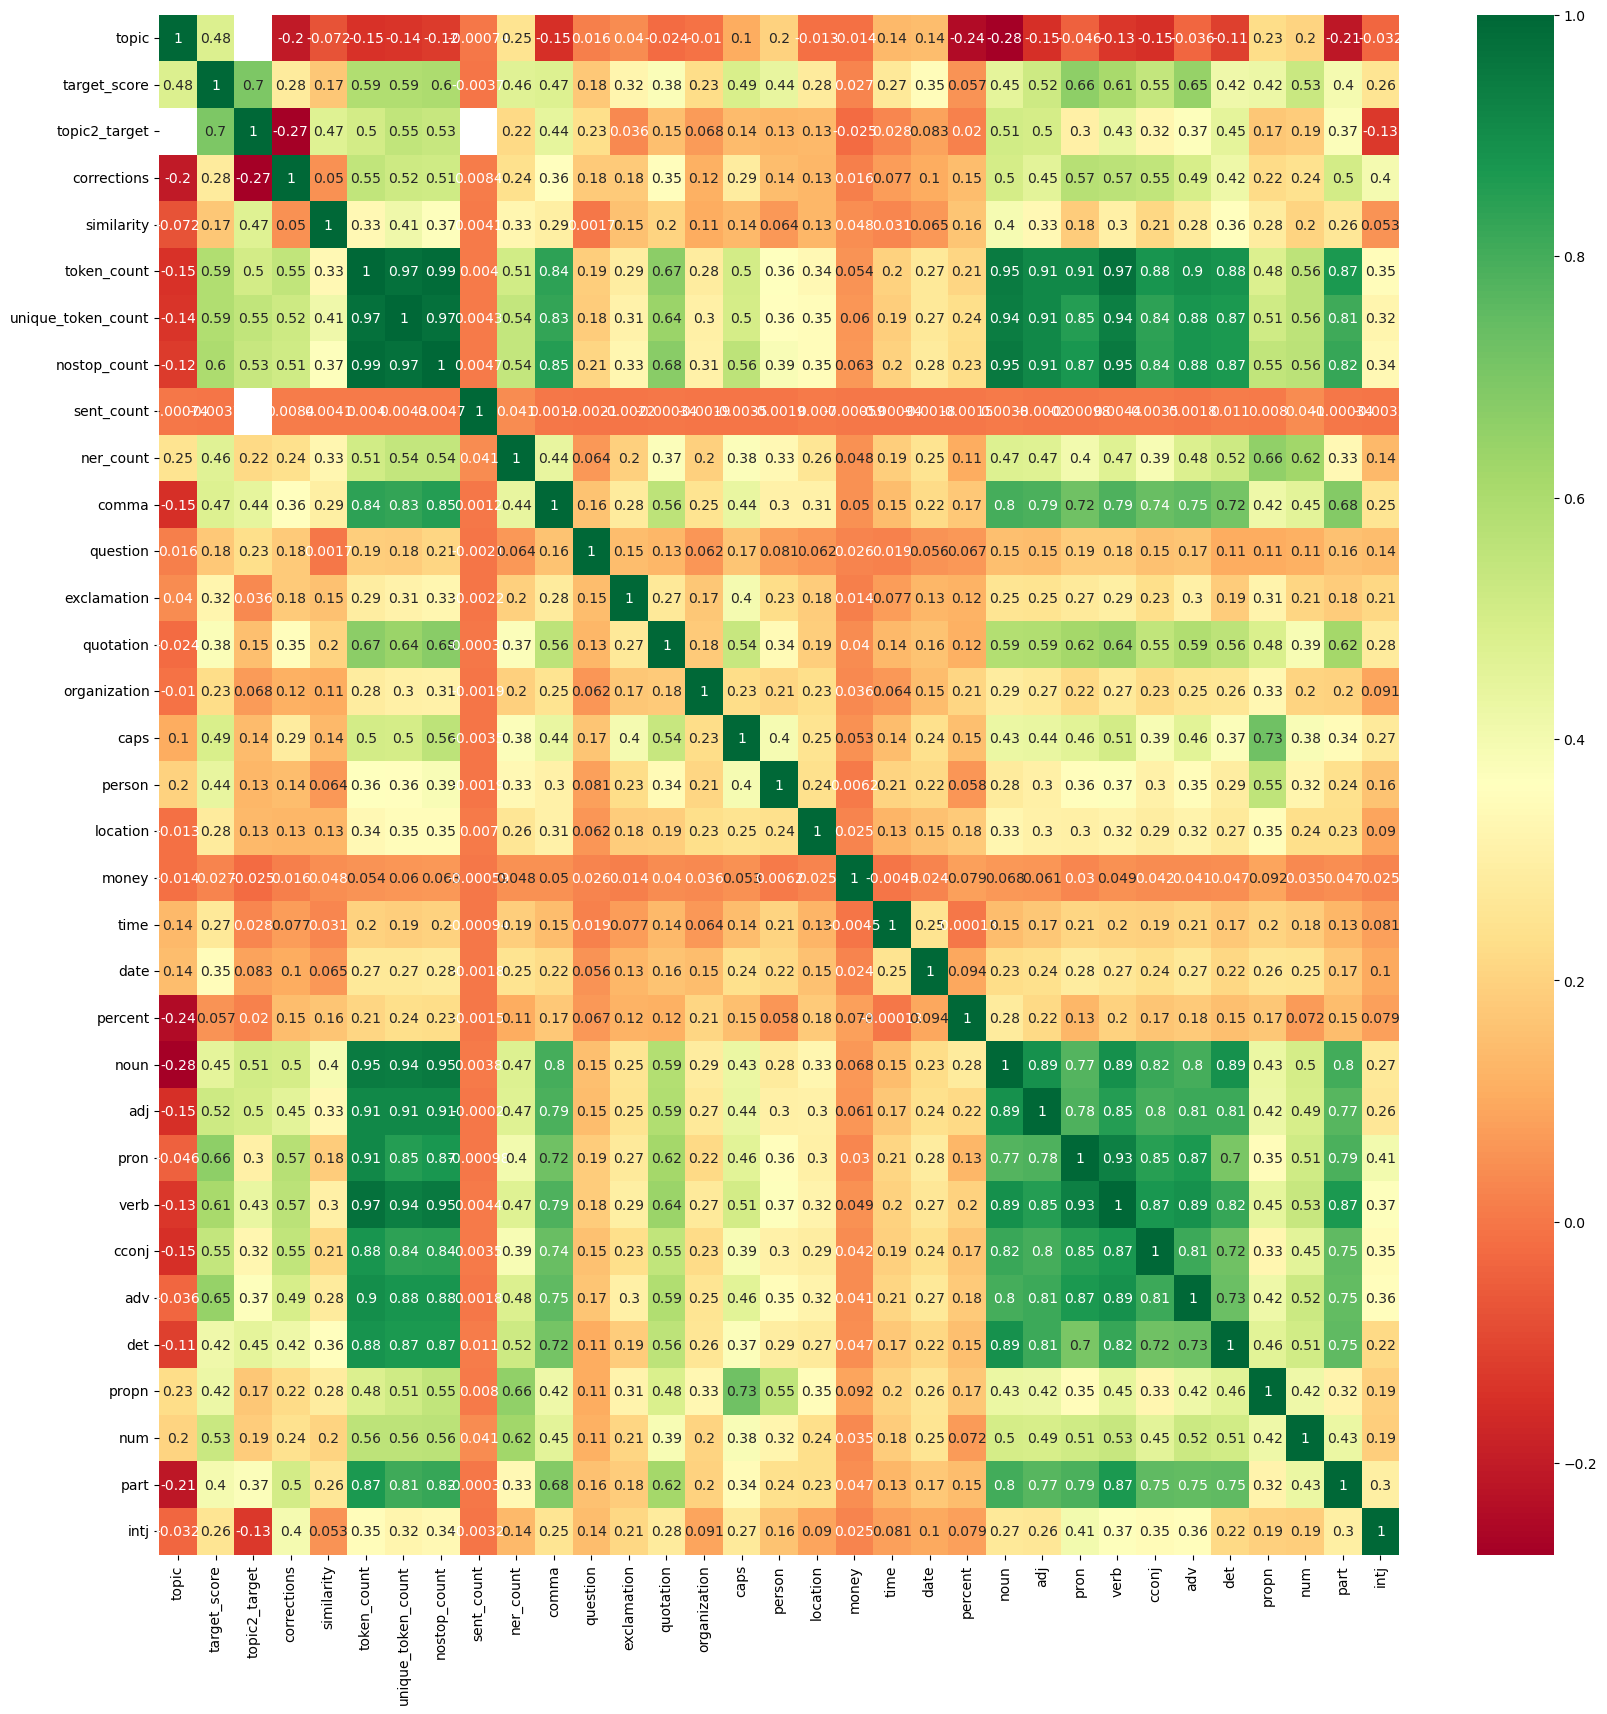

In [32]:
import seaborn as sns
corrmat = training_set.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

g=sns.heatmap(training_set[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [33]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

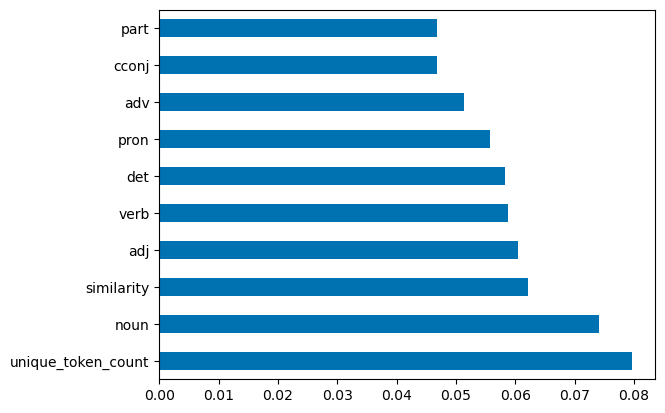

In [34]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [35]:
training_set.shape

(12976, 41)

In [36]:
selector = SelectKBest(f_regression, k=10) 


df = pd.DataFrame()

for topic in range(1, 9):
    kpredictors = []
    
    
    for p in predictors:
        if np.std(training_set[training_set.topic == topic][p], axis=0) != 0:
            kpredictors.append(p)
            
    
    X = training_set[training_set.topic == topic][kpredictors]
    y = training_set[training_set.topic == topic].target_score
    
    selector.fit(X, y)

    
    mask = selector.get_support(indices=True)

    selected_features = training_set[training_set.topic == topic][predictors].columns[mask]
    df["Topic " + str(topic)] = selected_features
df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,similarity,unique_token_count,similarity,unique_token_count,similarity,similarity,similarity,similarity
1,unique_token_count,ner_count,unique_token_count,ner_count,unique_token_count,unique_token_count,unique_token_count,unique_token_count
2,ner_count,percent,ner_count,comma,exclamation,ner_count,sent_count,sent_count
3,percent,noun,time,percent,time,exclamation,ner_count,ner_count
4,noun,adj,date,noun,date,time,percent,percent
5,adj,pron,percent,adj,percent,date,noun,noun
6,pron,verb,noun,pron,noun,noun,adj,pron
7,verb,cconj,adj,verb,adj,pron,pron,cconj
8,cconj,adv,pron,adv,pron,verb,cconj,adv
9,adv,num,verb,det,verb,det,adv,num


In [37]:
def evaluate(df, topic, features, model):

    X = df[df['topic'] == topic][features]
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
    
    pipeline = Pipeline(model)
    pipeline.fit(X_train, y_train)

    
    y_pred = pipeline.predict(X_test)

    return quadratic_weighted_kappa(y_pred, y_test)

In [38]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator
def mean_quadratic_weighted_kappa(kappas, weights=None):
    kappas = np.array(kappas, dtype=float)
    if weights is None:
        weights = np.ones(np.shape(kappas))
    else:
        weights = weights / np.mean(weights)

    kappas = np.array([min(x, .999) for x in kappas])
    kappas = np.array([max(x, -.999) for x in kappas])

    z = 0.5 * np.log((1 + kappas) / (1 - kappas)) * weights
    z = np.mean(z)
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

In [39]:
predictors = [  
                
                'corrections',
                'similarity',
                'token_count',
                'unique_token_count',
                'nostop_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'organization',
                'caps',
                'person',
                'location',
                'money',
                'time',
                'date',
                'percent',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'det',
                'propn',
                'num',
                'part',
                'intj'
                ]
models = [
            [('scaler', StandardScaler()),('linearSVC', LinearSVC(C=0.01))] ,
            [('scaler', StandardScaler()),('lm', LinearRegression())], 
            [('rf', RandomForestRegressor(random_state=26))],  
            [('en', ElasticNet(l1_ratio=0.01, alpha=0.1, max_iter=100000, random_state=26))] 
        ]

for steps in models:
    kappas = []
    weights = []
    for topic in range(1,9):
        kappas.append(evaluate(training_set, topic, predictors, steps))
        weights.append(len(training_set[training_set.topic==topic]))

    mqwk = mean_quadratic_weighted_kappa(kappas, weights)
    print(steps)
    print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))
    print('')

[('scaler', StandardScaler()), ('linearSVC', LinearSVC(C=0.01))]
Weighted by topic Kappa score: 0.5839

[('scaler', StandardScaler()), ('lm', LinearRegression())]
Weighted by topic Kappa score: 0.6353

[('rf', RandomForestRegressor(random_state=26))]
Weighted by topic Kappa score: 0.6305

[('en', ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=100000, random_state=26))]
Weighted by topic Kappa score: 0.6231



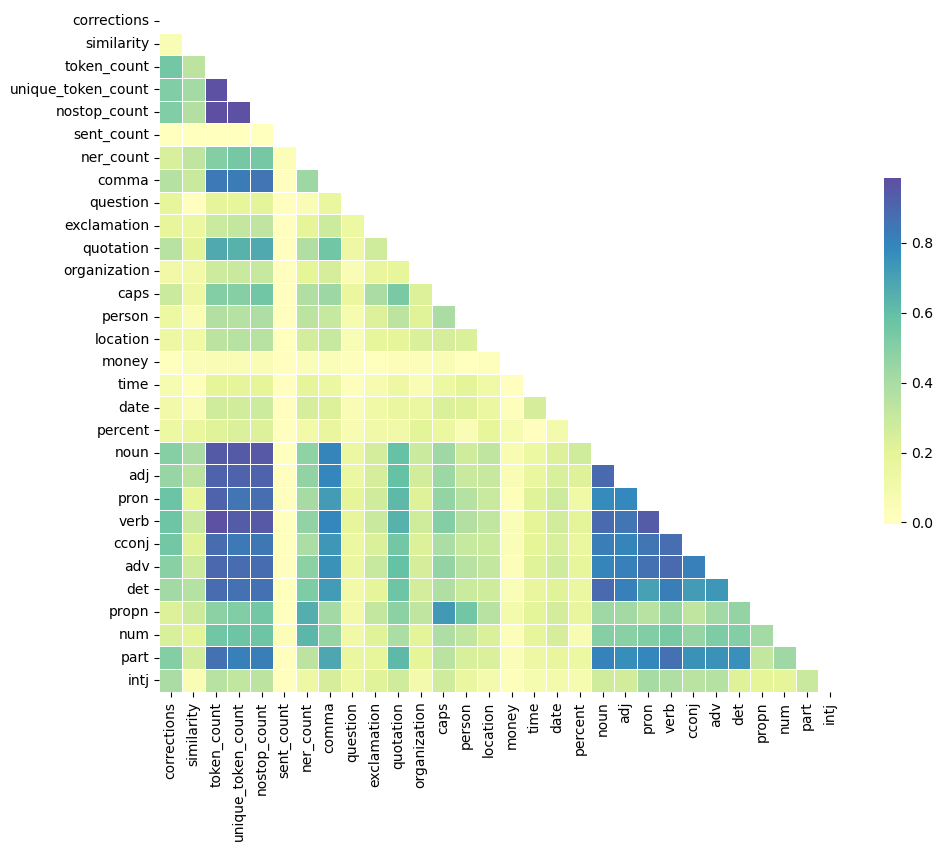

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr = training_set[predictors].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

g = sns.heatmap(corr, mask=mask, cmap='Spectral', center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

training_set['l_essay'] = training_set['lemma'].apply(' '.join)

vectorizer = TfidfVectorizer(max_df=.2, 
                             min_df=3, 
                             max_features=2000,
                             stop_words='english')
tfidf_matrix = vectorizer.fit_transform(training_set.l_essay)
tfidf_matrix.shape


(12976, 2000)

In [44]:
combined_dense = pd.concat([pd.DataFrame(tfidf_matrix.todense()), 
                            training_set[predictors], 
                            training_set['topic'], 
                            training_set['target_score']], axis=1)
combined_dense.shape


(12976, 2032)

In [51]:
def tf_evaluate(df, topic):
    paramgrid = {'l1_ratio': [.01, .1, .5, .9], 'alpha': [0.01, .1, 1]}
    X = df[df['topic'] == topic].drop(['topic', 'target_score'], axis=1)
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    X.columns = X.columns.astype(str)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
    
    gs = GridSearchCV(ElasticNet(max_iter=100000, random_state=26), param_grid=paramgrid, cv=5)
    gs.fit(X_train, y_train)
    print('Topic', topic, 'best parameters:', gs.best_params_)
    y_pred = gs.predict(X_test)
    
    return quadratic_weighted_kappa(y_pred, y_test)

In [52]:
kappas = []
weights = []
for topic in range(1, 9):
    
    kappas.append(tf_evaluate(combined_dense, topic))
    weights.append(len(training_set[training_set.topic==topic]))
    
mqwk = mean_quadratic_weighted_kappa(kappas, weights=weights)
print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))

Topic 1 best parameters: {'alpha': 1, 'l1_ratio': 0.1}
Topic 2 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 3 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 4 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 5 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 6 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 7 best parameters: {'alpha': 0.01, 'l1_ratio': 0.9}
Topic 8 best parameters: {'alpha': 1, 'l1_ratio': 0.5}
Weighted by topic Kappa score: 0.6476


In [54]:
import pandas as pd

training_set.to_pickle('Final_model.pkl')